In [2]:
import os

In [3]:
%pwd


'd:\\office\\vc\\research'

In [51]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataPreProcessConfig:
    root_dir:Path
    processed_audio_dir:Path
    audio_path:Path

In [1]:
from cloner.constants import *
from cloner.utils.common import read_yaml, create_directories

In [ ]:
class ConfigurationManager:
    def __init__(
            self,
            config_filepath= CONFIG_FILE_PATH,
            params_filepath= PARAMS_FILE_PATH):
            
            self.config=read_yaml(config_filepath)
            self.params=read_yaml(params_filepath)

            create_directories([self.config.artifacts_root]) 

    def get_data_preprocess_config(self)-> DataPreProcessConfig:
          config=self.config.data_preprocessing #storing configuration  inside config variable
          create_directories([config.root_dir]) #creating artifact directory

          data_preprocess_config=DataPreProcessConfig( #defining return type
                root_dir=config.root_dir,
                processed_audio_dir=config.processed_audio_dir,
                audio_path=config.audio_path
          ) 

          return data_preprocess_config

In [ ]:
TTS_PATH = "D:/office/vc/TTS"
import sys
import os
from scipy.stats import norm
import numpy as np
from TTS.tts.datasets.formatters import *
from TTS.utils.audio import AudioProcessor
from TTS.config.shared_configs import BaseAudioConfig
from cloner import logger 
import librosa
CONFIG = BaseAudioConfig()
%matplotlib inline

In [79]:
class DataPreprocessor:
    def __init__(self,config: DataPreProcessConfig):
        self.config=config
        self.params=read_yaml(PARAMS_FILE_PATH)
        self.audio_processor=AudioProcessor

    def get_audio_processor(self)-> AudioProcessor:
        tuned_config = CONFIG.copy()
        tuned_config.update(self.params.get("reset", {}))
        tuned_config.update(self.params.get("tune_params", {}))
        logger.info("Initialized AudioProcessor with tuned config.")
        return AudioProcessor(**tuned_config)
    
    def melspectrogram(self, audio_path):
        logger.info(f"Generating mel-spectrogram for: {audio_path}")
        y, sr = librosa.load(audio_path, sr=self.params["tune_params"]["sample_rate"])
        mel_spectrogram = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_mels=self.params["tune_params"]["num_mels"],
            n_fft=self.params["tune_params"]["fft_size"],
            hop_length=self.params["tune_params"].get("hop_length") or 256
        )
        return mel_spectrogram

  
    def process_audio(self):
        root_dir=Path(self.config.root_dir)
        processed_audio_dir=Path(self.config.processed_audio_dir)
        audio_path=Path(self.config.audio_path)
        logger.info(f"Starting audio processing...")
        logger.info(f"Looking for WAV files in: {audio_path}")

        os.makedirs(processed_audio_dir, exist_ok=True)

        audio_files = list(audio_path.glob("*.wav"))
        logger.info(f"Found {len(audio_files)} audio files.")

        for audio_file in audio_files:
            try:
                mel_spec = self.melspectrogram(audio_file)
                mel_spec_file = Path(processed_audio_dir) / f"{audio_file.stem}.npy"
                np.save(mel_spec_file, mel_spec)
                logger.info(f"Processed and saved mel-spectrogram for {mel_spec_file}")

            except Exception as e:
                logger.error(f"Error processing {audio_file}: {e}")
        logger.info(f"Completed processing {len(audio_files)} files.")

In [80]:
try:
    config=ConfigurationManager()
    data_preprocess_config=config.get_data_preprocess_config()
    data_preprocess=DataPreprocessor(config=data_preprocess_config)
    data_preprocess.get_audio_processor()
    data_preprocess.process_audio()
    
except Exception as e:
    raise e

 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:12.5
 | > frame_length_ms:50
 | > ref_level_db:0
 | > fft_size:2400
 | > power:1.5
 | > preemphasis:0.98
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:False
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:45
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > win_length:1102
 | > hop_length:275


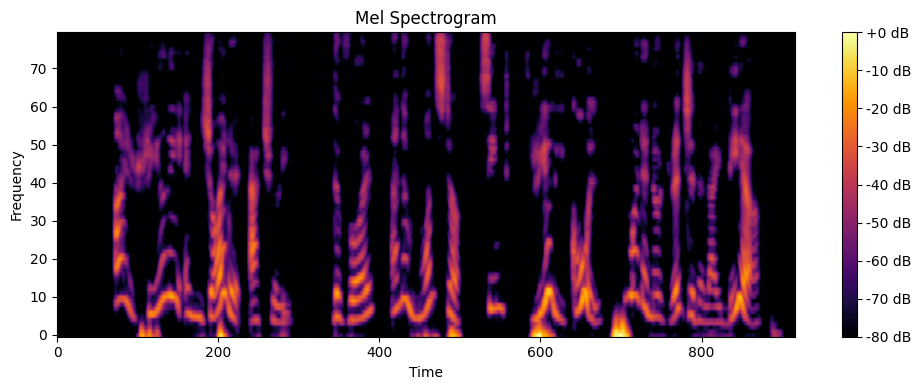

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import librosa

mel_spec = np.load('artifacts/data_preprocessing/processed_audio/LJ001-0010.npy')
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
mel_spec_db = np.clip(mel_spec_db, a_min=None, a_max=100)

plt.figure(figsize=(10, 4))
plt.imshow(mel_spec_db, aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
